# Information Processing Capacity Analysis
In this notebook, the analysis leading to the plots in the [Memory vs Nonlinearity paper](https://www.mdpi.com/2313-7673/9/12/755) are presented.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns
from simulator import NetworkSimulator
import pandas as pd
import Capacities.capacities as CAP
from utils import createNARMA10, createNARMA30, region_specific_IPC

# Some helper functions

def cap2vec(capacities,maxdel=1000,maxdeg=10):
    vec = np.zeros((maxdel,maxdeg))
    for idx in range(len(capacities)):
        delay=capacities[idx]['delay']
        degree=capacities[idx]['degree']
        if (delay<=maxdel) and (degree<=maxdeg):
            vec[delay-1,degree-1]+=capacities[idx]['score']
    return vec

def cap2mat(capacities,maxdel=1000,maxdeg=10,maxwin=10):
    vec = np.zeros((maxdel,maxwin,maxdeg))
    for idx in range(len(capacities)):
        delay=capacities[idx]['delay']
        degree=capacities[idx]['degree']
        win=capacities[idx]['window']
        if (delay<=maxdel) and (degree<=maxdeg) and (win<=maxwin):
            vec[delay-1, win-1, degree-1]+=capacities[idx]['score']
    return vec

def full_IPC(inputs, states, maxdel=35, maxdeg=2, maxvars=2):
    Citer=CAP.capacity_iterator(mindel=1,mindeg=1, maxdeg=maxdeg, minvars=1,maxvars=maxvars, maxdel=maxdel, delskip=100,
                            m_delay=False,
                            m_windowpos=False, m_window=False, m_powerlist=False,m_variables=False,
                            m_degrees=False, minwindow=0, maxwindow=31)#, verbose = 1)
    totalcap, allcaps, numcaps, nodes = Citer.collect(inputs, states)
    return allcaps

# Task capacity
Load Taks capacity for NARMA-30. New task caps can be computed from [computeTaskCaps.py](../ipc-scripts/computeTaskCaps.py).

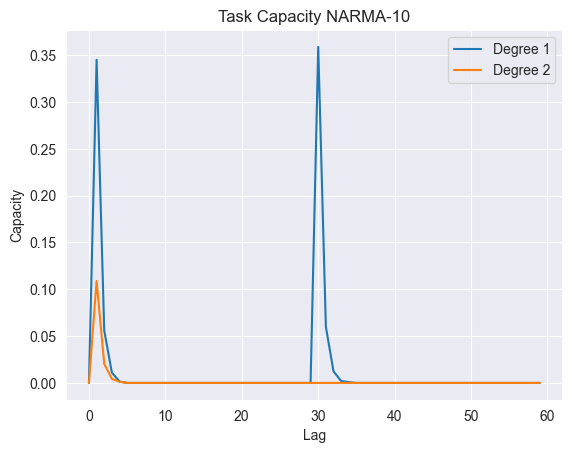

In [16]:
caps_path = "../results/ipc-results/narma_30_task_caps_2025-02-27.p"
with open(caps_path, "rb") as f:
    tc_dict = pkl.load(f)
task_caps = tc_dict['taskCap']
maxdel = tc_dict['maxdel']
maxdeg = tc_dict['maxdeg']
V10 = cap2vec(task_caps, maxdel = maxdel, maxdeg = maxdeg)
plt.plot(V10)
plt.ylabel('Capacity')
plt.xlabel('Lag')
plt.title('Task Capacity NARMA-10')
plt.legend(['Degree ' + str(i + 1) for i in range(maxdeg)])

# Performance Estimate using task-overlap metric based on region-specific IPC

Task IPC is first computed, then the non-zero task-capacities define a specific task-relevant IPC region. The region-specific IPC is then computed for random networks with a gridsearch over spectral radius and leak rate. Here we load existing gridsearch results. Generating new results can be done with [randomNetOverlap.py](../ipc-scripts/randomNetOverlap.py).


In [17]:
with open('../results/ipc-results/final_results_unopt_6.p', 'rb') as f:
    gridsearch_results = pkl.load(f)

In [18]:
results_df = pd.DataFrame(gridsearch_results)
results_df['sr'] = results_df['sr'].round(2)
results_df['leak'] = results_df['leak'].round(2)
df_bl = results_df[results_df['net_type'] == 'ESN']
df_ddn = results_df[results_df['net_type'] == 'DDN']
df_ddn.head()

,sr,leak,task_p,regional_cap,overlap,net_type
1,0.5,0.30,0.622819,"[{'degree': 1, 'variables': 1, 'powerlist': [1...",0.698692,DDN
3,0.5,0.30,0.625894,"[{'degree': 1, 'variables': 1, 'powerlist': [1...",0.618493,DDN
5,0.5,0.30,0.662610,"[{'degree': 1, 'variables': 1, 'powerlist': [1...",0.570308,DDN
7,0.5,0.36,0.630535,"[{'degree': 1, 'variables': 1, 'powerlist': [1...",0.619869,DDN
9,0.5,0.36,0.610623,"[{'degree': 1, 'variables': 1, 'powerlist': [1...",0.786051,DDN


<AxesSubplot: title={'center': 'DDN NARMA-30 NRMSE'}, xlabel='leak', ylabel='sr'>

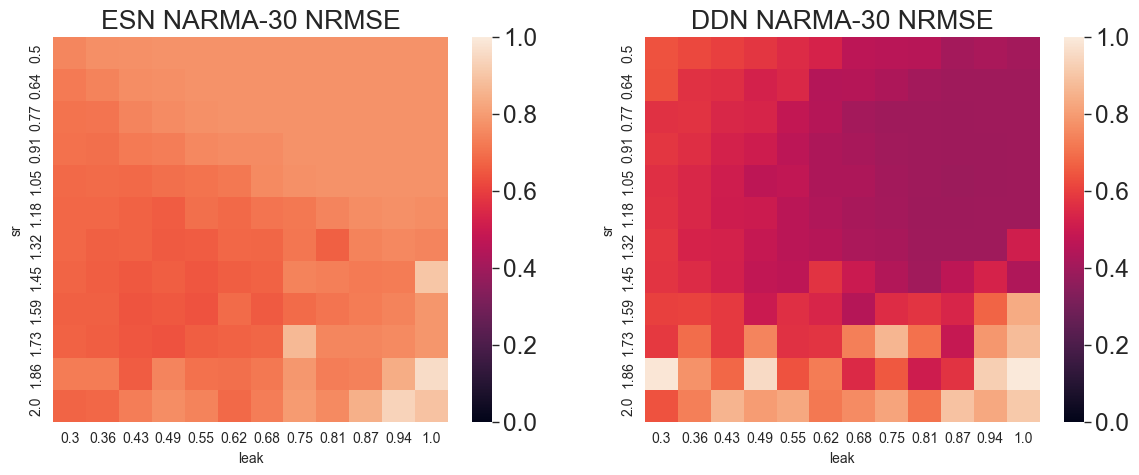

In [19]:
metr = 'task_p'
df_bl_hm = df_bl.pivot_table(index="sr", columns="leak", values=metr, aggfunc='mean')
df_ddn_hm = df_ddn.pivot_table(index="sr", columns="leak", values=metr, aggfunc='mean')

fig, ax = plt.subplots(1, 2, figsize=(14,5))
sns.set_theme(style="ticks", font_scale=2, palette='deep', context='paper')
ax[0].set_title('ESN NARMA-30 NRMSE')
sns.heatmap(df_bl_hm, ax=ax[0], vmin=0, vmax=1)
ax[1].set_title('DDN NARMA-30 NRMSE')
sns.heatmap(df_ddn_hm, ax=ax[1], vmin=0, vmax=1)
# plt.savefig("figs/gridsearch_N30.svg")


<AxesSubplot: title={'center': 'DDN-NARMA-30 overlap score'}, xlabel='leak', ylabel='sr'>

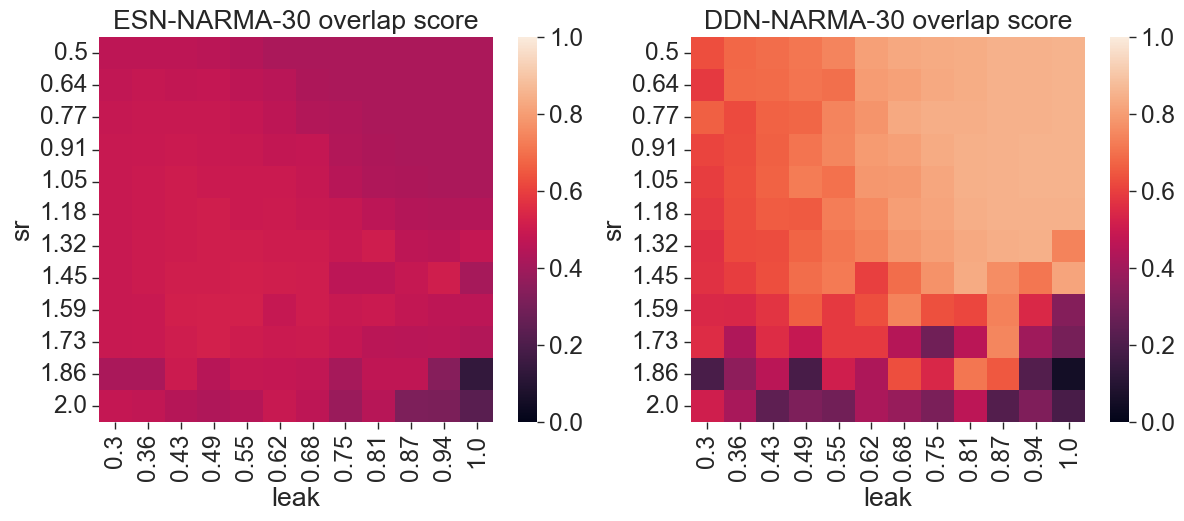

In [20]:
metr = 'overlap'
df_bl_hm = df_bl.pivot_table(index="sr", columns="leak", values=metr, aggfunc='mean')
df_ddn_hm = df_ddn.pivot_table(index="sr", columns="leak", values=metr, aggfunc='mean')
fig, ax = plt.subplots(1, 2, figsize=(14,5))
sns.set_theme(style="ticks", font_scale=2, palette='deep', context='paper')
ax[0].set_title('ESN-NARMA-30 overlap score')
sns.heatmap(df_bl_hm, ax=ax[0], vmin=0, vmax=1)
ax[1].set_title('DDN-NARMA-30 overlap score')
sns.heatmap(df_ddn_hm, ax=ax[1], vmin=0, vmax=1)
# plt.savefig("figs/gridsearch_overlap_N30.svg")


(0.0, 0.9)

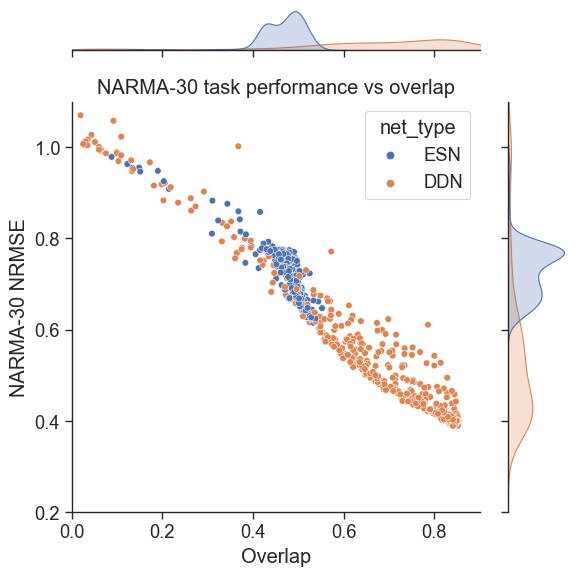

In [21]:
sns.set_theme(style="ticks", font_scale=1.5, palette='deep', context='paper')
sns.jointplot(results_df, x="overlap", y="task_p", hue='net_type')
plt.title('NARMA-30 task performance vs overlap')
plt.xlabel('Overlap')
plt.ylabel('NARMA-30 NRMSE')
plt.ylim(0.2, 1.1)
plt.tight_layout()
plt.xlim(0, 0.9)

# plt.savefig('figs/overlap_scatter.svg')

In [167]:
from utils import eval_candidate_lag_gridsearch_NARMA

data_train = np.array(createNARMA30(4000)).reshape((2, 4000))
data_val = np.array(createNARMA30(6000)).reshape((2, 6000))
ipc_in = data_val[0,:] * 4 - 1
sr_grid_size = 5
leak_grid_size = 5
sr_grid = np.linspace(0.1, 2, sr_grid_size)
leak_grid = np.linspace(0.3, 1, leak_grid_size)
reps = 2
print(sr_grid)
print(leak_grid)

total_reps = sr_grid_size * leak_grid_size * reps

results_full_ipc_2 = {
    'sr': [],
    'leak': [],
    'regional_cap': [],
    'net_type': []
}
def write_result_full_ipc(results, sr, leak, regional_cap, net_type):
    results['sr'].append(sr)
    results['leak'].append(leak)
    results['regional_cap'].append(regional_cap)
    results['net_type'].append(net_type)

i = 0
print('Total number of evaluations: ' + str(total_reps))
for sr in sr_grid:
    for leak in leak_grid:
        for rep in range(reps):
            i+=1
            print(str((i/total_reps)*100) + "% done")
            ddn_net, bl_net = get_random_ddn(100, sr, leak)
            
            sim_ddn = NetworkSimulator(ddn_net)
            sim_ddn.warmup(data_val[0, :400])
            ddn_states = sim_ddn.get_network_data(data_val[0, 400:])
            
            sim_bl = NetworkSimulator(bl_net)
            sim_bl.warmup(data_val[0, :400])
            bl_states = sim_bl.get_network_data(data_val[0, 400:])
            
            # evaluate on NARMA
            # _, val_performance_per_lag_ddn, _, _, ddn_states = eval_candidate_lag_gridsearch_NARMA(ddn_net, data_train, data_val, 400, alphas=alphas, return_states=True)
            # p_n_ddn = np.min(val_performance_per_lag_ddn[0])
            # print('ddn: ', p_n_ddn)
            # 
            # _, val_performance_per_lag_bl, _, _, bl_states = eval_candidate_lag_gridsearch_NARMA(bl_net, data_train, data_val, 400, alphas=alphas, return_states=True)
            # p_n_bl = np.min(val_performance_per_lag_bl[0])
            # print('bl: ', p_n_bl)
            # 
            # evaluate IPC   
            r_IPCs_ddn = full_IPC(ipc_in[400:], ddn_states.T, 60, 3)
            r_IPCs_bl = full_IPC(ipc_in[400:], bl_states.T, 60, 3)
            
            # # estimate overlap
            # overlap_ddn = estimate_from_IPC(task_allcaps_30, r_IPCs_ddn)
            # overlap_bl = estimate_from_IPC(task_allcaps_30, r_IPCs_bl)
            
            write_result_full_ipc(results_full_ipc_2, sr, leak, r_IPCs_bl, 'ESN')
            write_result_full_ipc(results_full_ipc_2, sr, leak, r_IPCs_ddn, 'DDN')

[0.1   0.575 1.05  1.525 2.   ]
[0.3   0.475 0.65  0.825 1.   ]
Total number of evaluations: 50
2.0% done
test
Estimated rank of state covariance matrix =  95
Total score for degree  1  =  29.69011421862854 (cumulative total =  29.69011421862854 )
Total score for degree  2  =  65.39893708080336 (cumulative total =  95.08905129943197 )
Total score for degree  3  =  1.097657243996011 (cumulative total =  96.18670854342798 )
Total capacity=96.187 (97.16 percent)
test
Estimated rank of state covariance matrix =  20
Total score for degree  1  =  6.667092489398322 (cumulative total =  6.667092489398322 )
Total score for degree  2  =  8.948824969778542 (cumulative total =  15.615917459176856 )
Total score for degree  3  =  1.9118498562475172 (cumulative total =  17.527767315424374 )
Total capacity=17.528 (17.70 percent)
4.0% done
test
Estimated rank of state covariance matrix =  99
Total score for degree  1  =  32.74274460278696 (cumulative total =  32.74274460278696 )
Total score for degree 

In [168]:
results_df = pd.DataFrame(results_full_ipc_2)
results_df['sr'] = results_df['sr'].round(2)
results_df['leak'] = results_df['leak'].round(2)

df_bl = results_df[results_df['net_type'] == 'ESN']
df_ddn = results_df[results_df['net_type'] == 'DDN']
bl_ipc = []
for IPC in df_bl['regional_cap']:
    cap_V = cap2vec(IPC, 60, 3)
    bl_ipc.append(cap_V)
av_caps_esn = np.mean(bl_ipc, 0)

ddn_ipc = []
for IPC in df_ddn['regional_cap']:
    cap_V = cap2vec(IPC, 60, 3)
    ddn_ipc.append(cap_V)
av_caps_ddn = np.mean(ddn_ipc, 0)


In [173]:
results_df = pd.DataFrame(results_full_ipc)
results_df['sr'] = results_df['sr'].round(2)
results_df['leak'] = results_df['leak'].round(2)

df_bl = results_df[results_df['net_type'] == 'ESN']
df_ddn = results_df[results_df['net_type'] == 'DDN']
bl_ipc_r = []
for IPC in df_bl['regional_cap']:
    cap_V = cap2vec(IPC, 60, 3)
    bl_ipc_r.append(cap_V)
av_caps_esn_r = np.mean(bl_ipc_r, 0)

ddn_ipc_r = []
for IPC in df_ddn['regional_cap']:
    cap_V = cap2vec(IPC, 60, 3)
    ddn_ipc_r.append(cap_V)
av_caps_ddn_r = np.mean(ddn_ipc_r, 0)


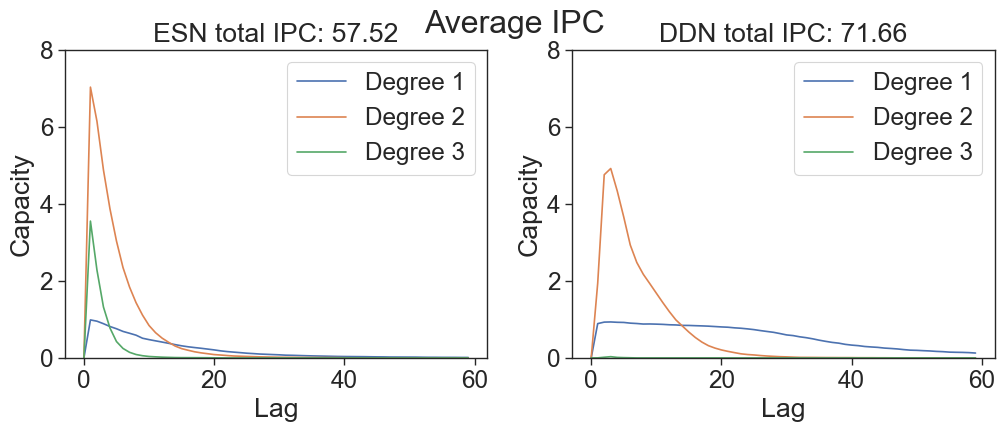

In [194]:

sns.set_theme(style="ticks", font_scale=2, palette='deep', context='paper')


fig, ax = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle("Average IPC")

ax[0].set_title("ESN total IPC: " + str(np.round(np.sum(av_caps_esn), 2)))
ax[0].plot(av_caps_esn)
ax[0].set_ylim(0, 8)
ax[0].set_ylabel('Capacity')
ax[0].set_xlabel('Lag')
ax[1].set_title("DDN total IPC: " + str(np.round(np.sum(av_caps_ddn), 2)))
ax[1].plot(av_caps_ddn)
ax[1].set_ylim(0, 8)
ax[1].set_ylabel('Capacity')
ax[1].set_xlabel('Lag')
ax[0].legend(['Degree 1','Degree 2','Degree 3'])
ax[1].legend(['Degree 1','Degree 2','Degree 3'])
plt.savefig('figs/average_caps_unopt.svg')

(0.0, 8.0)

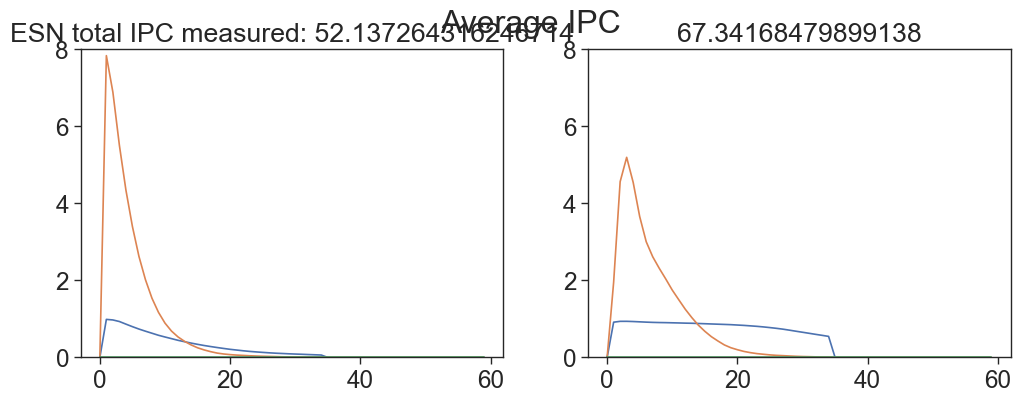

In [180]:

fig, ax = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle("Average IPC")
ax[0].set_title("ESN total IPC measured: " + str(np.sum(av_caps_esn_r)))
ax[0].plot(av_caps_esn_r)
ax[0].set_ylim(0, 8)
ax[1].set_title(np.sum(av_caps_ddn_r))
ax[1].plot(av_caps_ddn_r)
ax[1].set_ylim(0, 8)

In [69]:
from utils import eval_candidate_lag_gridsearch_NARMA

data_train = np.array(createNARMA30(4000)).reshape((2, 4000))
data_val = np.array(createNARMA30(8000)).reshape((2, 8000))
ipc_in = data_val[0,:] * 4 - 1

# Exact same nets
perf_ests_n30_ddn_id = []
perf_ests_n30_bl_id = []


alphas = [10e-7, 10e-5, 10e-3]
for i in range(50):
    # generate network
    rand_sr = 1.5
    rand_a = .9
    ddn_net, bl_net = get_random_ddn(100, rand_sr, rand_a)
    # evaluate on NARMA
    
    _, val_performance_per_lag_ddn, _, _, ddn_states = eval_candidate_lag_gridsearch_NARMA(ddn_net, data_train, data_val, 400, alphas=alphas, return_states=True)
    p_n_ddn = np.min(val_performance_per_lag_ddn[0])
    print('ddn: ', p_n_ddn)
    
    _, val_performance_per_lag_bl, _, _, bl_states = eval_candidate_lag_gridsearch_NARMA(bl_net, data_train, data_val, 400, alphas=alphas, return_states=True)
    p_n_bl = np.min(val_performance_per_lag_bl[0])
    print('bl: ', p_n_bl)
    
    # evaluate IPC    
    r_IPCs_ddn, _ = region_specific_IPC(ddn_states, task_allcaps_30, ipc_in[400:])
    r_IPCs_bl, _ = region_specific_IPC(bl_states, task_allcaps_30, ipc_in[400:])
    
    # estimate overlap
    overlap_ddn = estimate_from_IPC(task_allcaps_30, r_IPCs_ddn)
    overlap_bl = estimate_from_IPC(task_allcaps_30, r_IPCs_bl)
    
    perf_ests_n30_ddn_id.append([p_n_ddn, overlap_ddn])
    perf_ests_n30_bl_id.append([p_n_bl, overlap_bl])

ddn:  0.5379315220871813
bl:  0.7036195922479513
Estimated rank of state covariance matrix =  99
Estimated rank of state covariance matrix =  99
ddn:  0.6612075480435813
bl:  0.7481955996876131
Estimated rank of state covariance matrix =  99
Estimated rank of state covariance matrix =  99
ddn:  0.3880566887505901
bl:  0.7676797558796681
Estimated rank of state covariance matrix =  99
Estimated rank of state covariance matrix =  99
ddn:  0.3869294859953445
bl:  0.7340781286084398
Estimated rank of state covariance matrix =  99
Estimated rank of state covariance matrix =  99
ddn:  0.604892331354536
bl:  0.7093585918501807
Estimated rank of state covariance matrix =  99
Estimated rank of state covariance matrix =  99
ddn:  0.39460102085978965
bl:  0.7389098964860449
Estimated rank of state covariance matrix =  99
Estimated rank of state covariance matrix =  99
ddn:  0.5395248927071299
bl:  0.6706445630155662
Estimated rank of state covariance matrix =  99
Estimated rank of state covarianc

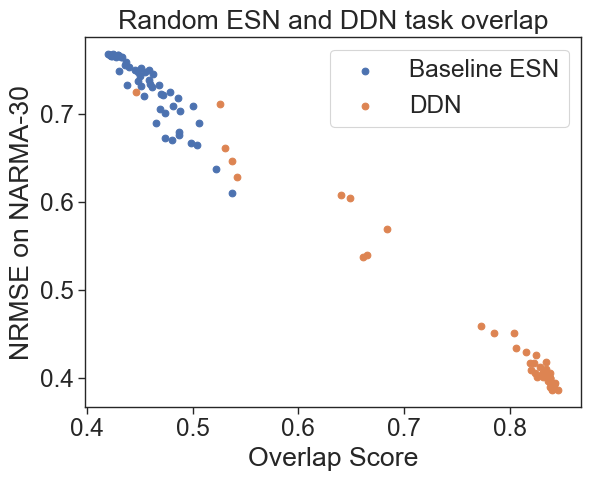

In [71]:
p_e = np.array(perf_ests_n30_bl_id, dtype=object)
plt.scatter(p_e[:,1], p_e[:,0])
p_e = np.array(perf_ests_n30_ddn_id, dtype=object)
plt.scatter(p_e[:, 1], p_e[:, 0])
# plt.ylim(0, 1)
plt.title('Random ESN and DDN task overlap')
plt.legend(['Baseline ESN', 'DDN'])
plt.ylabel('NRMSE on NARMA-30')
plt.xlabel('Overlap Score')
plt.savefig('figs/overlap_scores_rand_nets.svg')

# Task profile overlap of optimized networks

In [196]:
def get_best_scores(results_dict, max_best=True, lag_grid=False, agg=np.mean):
    
    val_scores = results_dict['validation performance']
    best_scores = []
    best_inds = []
    for i, pop_scores in enumerate(val_scores):
        if lag_grid:
            pop_scores = np.min(pop_scores, axis=-1)
        pop_scores = agg(pop_scores, axis=-1)
        if max_best:
            best_ind = np.argmax(pop_scores)
        else:
            best_ind = np.argmin(pop_scores)
        best_score = pop_scores[best_ind]
        best_scores.append(best_score)
        best_inds.append(best_ind)
    return best_scores, best_inds
# 
# def get_nth_best(results_dict, n=0, max_best=True, lag_grid=False, agg=np.mean):
#     val_scores = results_dict['validation performance']
#     best_scores = []
#     best_inds = []
#     for i, pop_scores in enumerate(val_scores):
#         if lag_grid:
#             pop_scores = np.min(pop_scores, axis=-1)
#         pop_scores = agg(pop_scores, axis=-1)
#         if max_best:
#             best_ind = np.argmax(pop_scores)
#         else:
#             best_ind = np.argmin(pop_scores)
#         best_score = pop_scores[best_ind]
#         best_scores.append(best_score)
#         best_inds.append(best_ind)
#     return best_scores, best_inds

In [200]:
ddn_n10_path = "../results/NARMA-10_results_23/NARMA10_old_ddn_results_n51_k4_date_2023-12-09.p"
ddn_n10_file = open(ddn_n10_path, 'rb')
ddn_n10_results_dict = pkl.load(ddn_n10_file)
print(ddn_n10_results_dict.keys())
alphas = alphas = [10e-7, 10e-5, 10e-3]
gmax = 200
print(ddn_n10_results_dict['example net'].N)
print(ddn_n10_results_dict['example net'].k)

best_scores, best_inds = get_best_scores(ddn_n10_results_dict, False, True, np.median)

dict_keys(['validation performance', 'parameters', 'evolutionary strategy', 'cma stds', 'example net', 'train data', 'validation data'])
51
4


In [198]:
# sanity check
from utils import createNARMA10
from utils import eval_candidate_lag_gridsearch_NARMA
data_train = np.array(createNARMA10(8000)).reshape((2, 8000))
data_test = np.array(createNARMA10(4000)).reshape((2, 4000))

alphas = [10e-7, 10e-5, 10e-3]
ex_net = ddn_n10_results_dict['example net']
pars = ddn_n10_results_dict['parameters']
test_perfs = []
for gen, best_ind in enumerate(best_inds[:30]):
    par = pars[gen, best_ind]
    ts = []
    for i in range(5):
        net = ex_net.get_new_network_from_serialized(par)
        train, test, _ = eval_candidate_lag_gridsearch_NARMA(net, data_train, data_test, alphas=alphas)
        t = np.min(test)
        ts.append(t)
    test_perf = np.mean(ts)
    print(gen, test_perf)
    test_perfs.append(test_perf)

0 0.36276915816863087
1 0.37409813862219615


KeyboardInterrupt: 

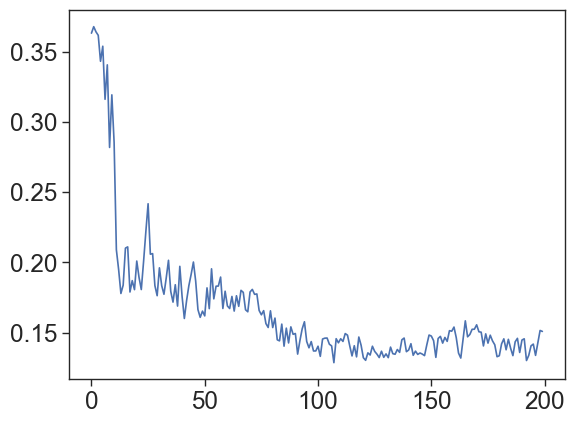

In [201]:
# plt.plot(test_perfs)
plt.plot(best_scores)

In [202]:
bl_n10_path = "../results/NARMA-10_results_23/NARMA10_old_bl_results_n51_k4_date_2024-03-18.p"
bl_n10_file = open(bl_n10_path, 'rb')
bl_n10_results_dict = pkl.load(bl_n10_file)
print(bl_n10_results_dict.keys())
alphas = [10e-7, 10e-5, 10e-3]
gmax = 200
print(bl_n10_results_dict['example net'].N)
print(bl_n10_results_dict['example net'].k)

best_scores, best_inds = get_best_scores(bl_n10_results_dict, False, True, np.median)

dict_keys(['validation performance', 'parameters', 'evolutionary strategy', 'cma stds', 'example net', 'train data', 'validation data'])
51
4


In [13]:
# sanity check
from utils import createNARMA10
from utils import eval_candidate_lag_gridsearch_NARMA
data_train = np.array(createNARMA10(8000)).reshape((2, 8000))
data_test = np.array(createNARMA10(4000)).reshape((2, 4000))

alphas = [10e-7, 10e-5, 10e-3]
ex_net = bl_n10_results_dict['example net']
pars = bl_n10_results_dict['parameters']
test_perfs = []
for gen, best_ind in enumerate(best_inds[:20]):
    par = pars[gen, best_ind]
    net = ex_net.get_new_network_from_serialized(par)
    train, test, _ = eval_candidate_lag_gridsearch_NARMA(net, data_train, data_test, alphas=alphas)
    t = np.min(test)
    print(gen, t)
    test_perfs.append(t)

0 0.3855885479255566
1 0.35361136689684763
2 0.36424951787744025
3 0.3586843054703562
4 0.34568643893545603
5 0.3173474245378657
6 0.3411213852014425
7 0.3497424725405123
8 0.39253631160803143
9 0.34282153747906846
10 0.3167039521221537
11 0.3612767715614634
12 0.37136880037744563
13 0.364016966170754
14 0.334784234781682
15 0.32235306647826956
16 0.36931027447003967
17 0.32374077635610576
18 0.34543816619864265
19 0.35585048115438433


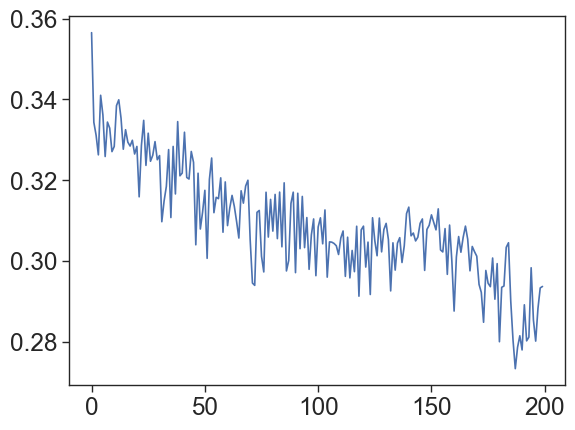

In [203]:
# plt.plot(test_perfs)
plt.plot(best_scores)
# plt.ylim(0, .7)

In [204]:
ddn_n30_path = "../results/NARMA-30_results_23/NARMA30_old_ddn_results_n101_k4_date_2023-12-11.p"
ddn_n30_file = open(ddn_n30_path, 'rb')
ddn_n30_results_dict = pkl.load(ddn_n30_file)
print(ddn_n30_results_dict.keys())
alphas = [10e-7, 10e-5, 10e-3]
gmax = 200
print(ddn_n30_results_dict['example net'].N)
print(ddn_n30_results_dict['example net'].k)

best_scores, best_inds = get_best_scores(ddn_n30_results_dict, False, True, np.median)

dict_keys(['validation performance', 'parameters', 'evolutionary strategy', 'cma stds', 'example net', 'train data', 'validation data'])
101
4


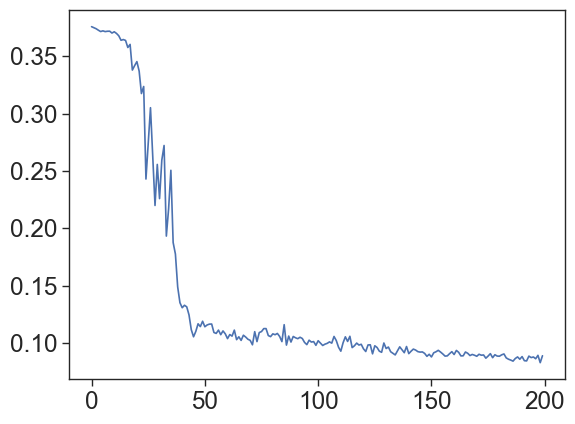

In [205]:
plt.plot(best_scores)

In [206]:
bl_n30_path = "../results/NARMA-30_results_23/NARMA30_old_bl_results_n101_k4_date_2024-03-18.p"
bl_n30_file = open(bl_n30_path, 'rb')
bl_n30_results_dict = pkl.load(bl_n30_file)
print(bl_n30_results_dict.keys())
alphas = [10e-7, 10e-5, 10e-3]
gmax = 200
print(bl_n30_results_dict['example net'].N)
print(bl_n30_results_dict['example net'].k)
best_scores, best_inds = get_best_scores(bl_n30_results_dict, False, True, np.median)

dict_keys(['validation performance', 'parameters', 'evolutionary strategy', 'cma stds', 'example net', 'train data', 'validation data'])
101
4


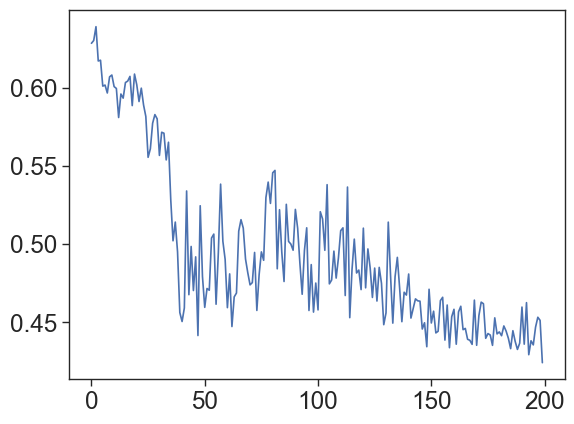

In [207]:
plt.plot(best_scores)

## measure best net performance and regional IPC

In [359]:
from utils import eval_candidate_lag_gridsearch_NARMA

def regional_IPC_evo(evo_dict, task_caps, train_data, test_data, alphas, reps_per_cand=5, warmup=400, max_gen=200, interval=10, use_test_for_ipc=True):
    gen_list = np.arange(0, max_gen, interval)
    best_scores, best_inds = get_best_scores(evo_dict, False, True)
    ex_net = evo_dict['example net']
    
    performance_and_ipc = []

    if use_test_for_ipc:
        ipc_in = test_data[0, warmup:]
    else:
        ipc_in = train_data[0, warmup:]

    ipc_in = ipc_in * 4 - 1
    
    for gen in gen_list:
        print('Gen', gen)
        best_i = best_inds[gen]
        par = evo_dict['parameters'][gen, best_i]
        print('--- Evaluating candidate on test data and computing regional IPC')
        t_gen = []
        r_IPCs_gen = []
        for i in range(reps_per_cand):
            net = ex_net.get_new_network_from_serialized(par)
            _, test, _, train_states, val_states = eval_candidate_lag_gridsearch_NARMA(net, train_data, test_data, warmup=warmup, alphas=alphas, return_states=True)
            best_task_lag = np.argmin(test)
            print('--- Task lag: ' + str(best_task_lag))
            t_gen.append(test[best_task_lag])
            
            # evaluate IPC
            if use_test_for_ipc:
                ipc_states = val_states
            else:
                ipc_states = train_states
                
            ipc_in_clipped = ipc_in
            if best_task_lag > 0:
                ipc_in_clipped = ipc_in[:-best_task_lag]
            ipc_states_clipped = ipc_states[best_task_lag:]
     
            r_IPCs, total_measured_IPC = region_specific_IPC(ipc_states_clipped, task_caps, ipc_in_clipped)
            # overlap = estimate_from_IPC(task_caps, r_IPCs, degrees=[2])
            # overlap_gen.append(overlap)
            r_IPCs_gen.append(r_IPCs)
        print('val_score during evo: ' + str(best_scores[gen]))
        print('------ Test performance: ' + str(np.mean(t_gen)))
        # print('------ Overlap: ' + str(np.mean(overlap_gen)))
        
        performance_and_ipc.append((t_gen, r_IPCs_gen))
    return performance_and_ipc

def debug_candidate(evo_dict, gen, task_caps, train_data, test_data, alphas, warmup=400):
    best_scores, best_inds = get_best_scores(evo_dict, False, True)
    ipc_in = test_data[0, warmup:]
    ipc_in = ipc_in * 4 - 1
    print('Score validation during evo: ' + str(best_scores[gen]))
    i = best_inds[gen]
    par = evo_dict['parameters'][gen, i]
    ex_net = evo_dict['example net']
    # net = ex_net.get_new_network_from_serialized(par)
    print('Now recomputing test scores: ')
    for i in range(5):
        net = ex_net.get_new_network_from_serialized(par)
        # sim = NetworkSimulator(net)
        # sim.visualize(train_data[0, :])
        _, test, _, train_states, val_states = eval_candidate_lag_gridsearch_NARMA(net, train_data, test_data,      warmup=warmup, alphas=alphas, return_states=True)
        ipc_states = val_states
        best_task_lag = np.argmin(test)
        ipc_in_clipped = ipc_in
        if best_task_lag > 0:
            ipc_in_clipped = ipc_in[:-best_task_lag]
        ipc_states_clipped = ipc_states[best_task_lag:]
        f_ipc = full_IPC(ipc_in_clipped, ipc_states_clipped, 40, 2, 2)
        cap_V = cap2vec(f_ipc, 40, 2)
        plt.figure()
        plt.plot(cap_V)
        plt.plot(V30)
        r_IPCs, total_measured_IPC = region_specific_IPC(ipc_states_clipped, task_caps, ipc_in_clipped)
        overlap = estimate_from_IPC(task_caps, r_IPCs, degrees=[2])
        print(test[best_task_lag], overlap)
        plt.title(overlap)
    # val_scores_candidate = best_scores[gen, :, :]
    # index_candidate = best_inds

Score validation during evo: 0.10605128726351017
Now recomputing test scores: 
test
Estimated rank of state covariance matrix =  100
Total score for degree  1  =  27.776023307968455 (cumulative total =  27.776023307968455 )
Total score for degree  2  =  42.673752419778985 (cumulative total =  70.44977572774744 )
Total capacity=70.450 (70.45 percent)
Estimated rank of state covariance matrix =  100
2
2
2
2
0.09740406474587025 0.09611239603342182
test
Estimated rank of state covariance matrix =  100
Total score for degree  1  =  27.34820908318934 (cumulative total =  27.34820908318934 )
Total score for degree  2  =  35.40377249550211 (cumulative total =  62.751981578691456 )
Total capacity=62.752 (62.75 percent)
Estimated rank of state covariance matrix =  100
2
2
2
2
0.1001018391871973 0.09661928358681517
test
Estimated rank of state covariance matrix =  100
Total score for degree  1  =  28.796054649411115 (cumulative total =  28.796054649411115 )
Total score for degree  2  =  42.723192

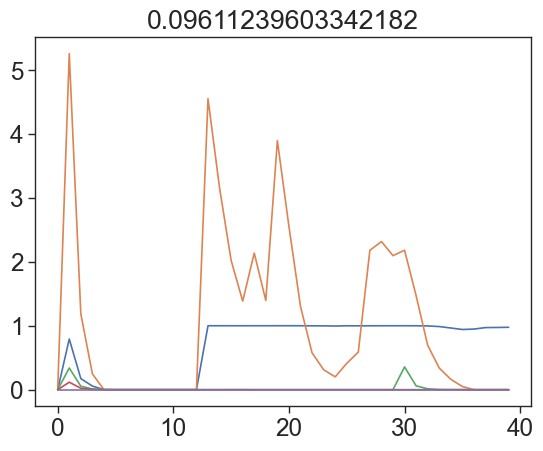

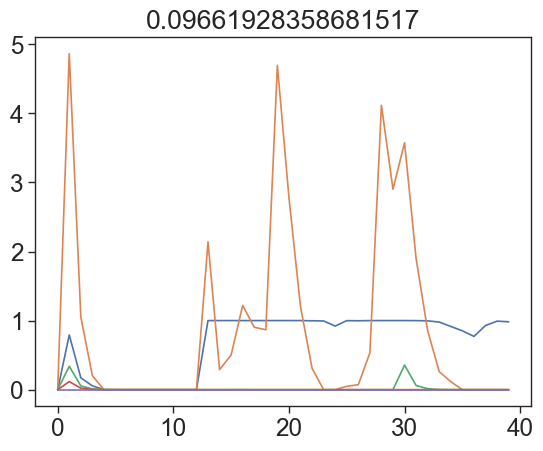

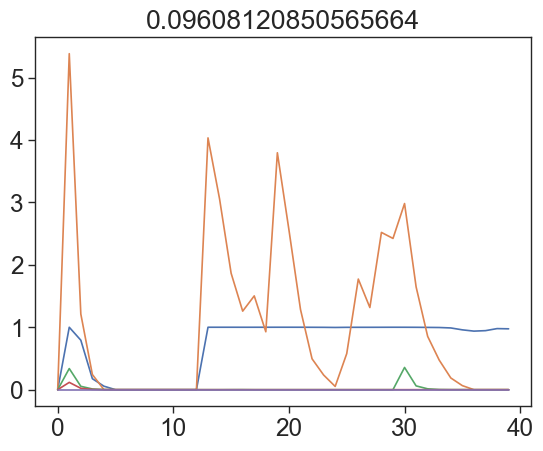

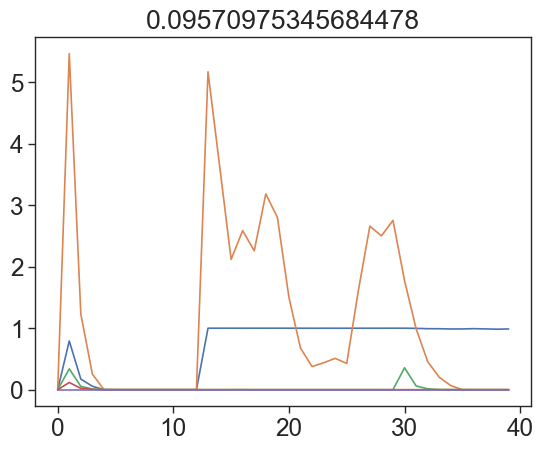

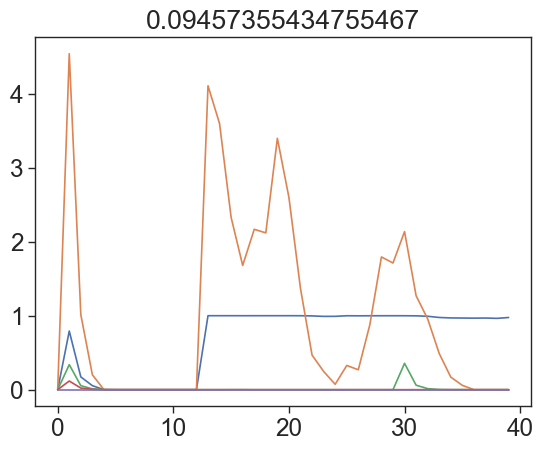

In [332]:
debug_candidate(ddn_n30_results_dict, 80, task_allcaps_30, data_train, data_test, alphas)

(0.0, 60.0)

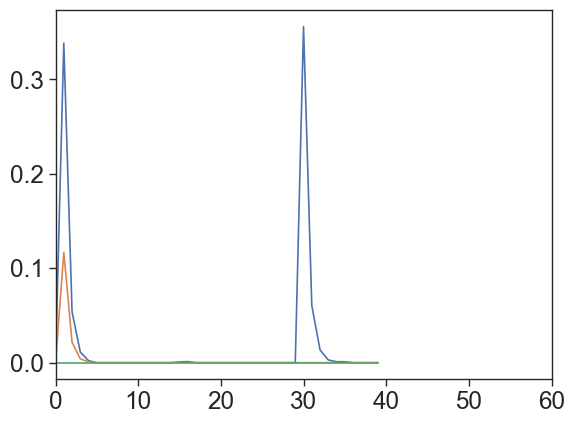

In [295]:
plt.plot(V30)
plt.xlim(0, 60)

In [497]:
data_train = np.array(createNARMA30(5000)).reshape((2, 5000))
data_test = np.array(createNARMA30(7000)).reshape((2, 7000))
alphas = [10e-7, 10e-5, 10e-3]

p_ipc_bl = regional_IPC_evo(bl_n30_results_dict, task_allcaps_30, data_train, data_test, alphas)
p_ipc_ddn = regional_IPC_evo(ddn_n30_results_dict, task_allcaps_30, data_train, data_test, alphas)


Gen 0
--- Evaluating candidate on test data and computing regional IPC
--- Task lag: 0
Estimated rank of state covariance matrix =  100
--- Task lag: 0
Estimated rank of state covariance matrix =  100
--- Task lag: 0
Estimated rank of state covariance matrix =  100
--- Task lag: 0
Estimated rank of state covariance matrix =  100
--- Task lag: 0
Estimated rank of state covariance matrix =  100
val_score during evo: 0.6446197293991032
------ Test performance: 0.6437143613556466
Gen 10
--- Evaluating candidate on test data and computing regional IPC
--- Task lag: 0
Estimated rank of state covariance matrix =  100
--- Task lag: 0
Estimated rank of state covariance matrix =  100
--- Task lag: 0
Estimated rank of state covariance matrix =  100
--- Task lag: 0
Estimated rank of state covariance matrix =  100
--- Task lag: 0
Estimated rank of state covariance matrix =  100
val_score during evo: 0.6178840150228279
------ Test performance: 0.6243800506340457
Gen 20
--- Evaluating candidate on te

In [498]:
# with open('ddn_r_ipc_3.p', 'wb') as file:
#     pkl.dump(p_ipc_ddn, file)
# 
# with open('bl_r_ipc_3.p', 'wb') as file:
#     pkl.dump(p_ipc_bl, file)


In [510]:
with open('ddn_r_ipc_3.p', 'rb') as file:
    p_ipc_ddn = pkl.load(file)

with open('bl_r_ipc_3.p', 'rb') as file:
    p_ipc_bl = pkl.load(file)

def write_opt_ipc(dict, gen, test_p, overlap):
    dict['gen'].append(gen)
    dict['test performance'].append(test_p)
    dict['overlap'].append(overlap)

p_ipc_dict_ddn = {
    'gen' : [],
    'test performance': [],
    'overlap': []
}

p_ipc_dict_bl = {
    'gen' : [],
    'test performance': [],
    'overlap': []
}
for gen, res in enumerate(p_ipc_ddn):
    r_ipcs = res[1]
    test_perfs = res[0]
    for i in range(len(test_perfs)):
        r_ipc = r_ipcs[i]
        overlap = estimate_from_IPC(task_allcaps_30, r_ipc, degrees=[1, 2])
        test_perf = test_perfs[i]
        write_opt_ipc(p_ipc_dict_ddn, gen * 10, test_perf, overlap)

for gen, res in enumerate(p_ipc_bl):
    r_ipcs = res[1]
    test_perfs = res[0]
    for i in range(len(test_perfs)):
        r_ipc = r_ipcs[i]
        overlap = estimate_from_IPC(task_allcaps_30, r_ipc, degrees=[1, 2])
        test_perf = test_perfs[i]
        write_opt_ipc(p_ipc_dict_bl, gen * 10, test_perf, overlap)


Text(0.5, 1.0, 'NARMA-30 Optimized Networks: overlap and performance')

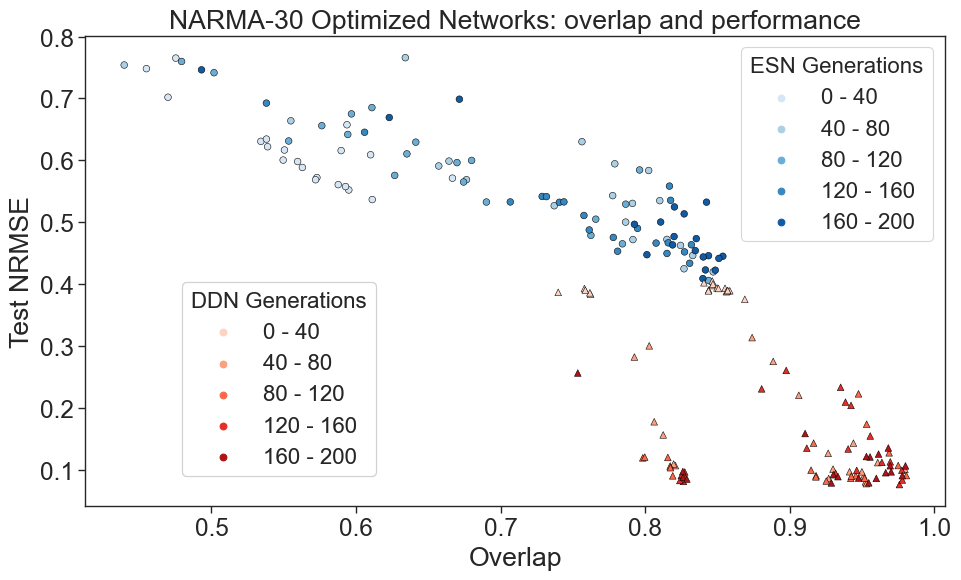

In [511]:
ddn_df = pd.DataFrame(p_ipc_dict_ddn)
bl_df = pd.DataFrame(p_ipc_dict_bl)

sns.set_theme(style="ticks", font_scale=2, palette='deep', context='paper')
fig, ax = plt.subplots(figsize=(10, 6))

n_bins = 5
n_steps = int(200/n_bins)
gen_bins = [str(i * n_steps) + ' - ' + str((i+1) * n_steps) for i in range(n_bins)]

bl_palette = sns.color_palette("Blues", len(gen_bins))
bl_df['Generation'] = pd.cut(bl_df['gen'], bins=n_bins, labels=gen_bins)

sns.scatterplot(bl_df, ax=ax, x='overlap', y='test performance', hue='Generation', palette=bl_palette, marker='o', edgecolor="black")

ddn_palette = sns.color_palette("Reds", len(gen_bins))
ddn_df['Generation'] = pd.cut(ddn_df['gen'], bins=5, labels=gen_bins)

sns.scatterplot(ddn_df, ax=ax, x='overlap', y='test performance', hue='Generation', palette=ddn_palette, marker='^', edgecolor="black")

handles_bl, labels_bl = ax.get_legend_handles_labels()
legend_bl = ax.legend(handles_bl[:len(gen_bins)], labels_bl[:len(gen_bins)], title="ESN Generations", loc='upper left', bbox_to_anchor=(0.75, 1), fontsize='small', title_fontsize='small')

handles_ddn, labels_ddn = ax.get_legend_handles_labels()
legend_ddn = ax.legend(handles_ddn[len(gen_bins):], labels_ddn[len(gen_bins):], title="DDN Generations", loc='upper left', bbox_to_anchor=(0.1, 0.5), fontsize='small', title_fontsize='small')
ax.add_artist(legend_bl)
ax.add_artist(legend_ddn)

plt.tight_layout()
plt.ylabel('Test NRMSE')
plt.xlabel('Overlap')
plt.title('NARMA-30 Optimized Networks: overlap and performance')
# plt.savefig('figs/optimized_scatter_overlap.svg')

In [512]:
data_train = np.array(createNARMA10(5000)).reshape((2, 5000))
data_test = np.array(createNARMA10(7000)).reshape((2, 7000))
alphas = [10e-7, 10e-5, 10e-3]

p_ipc_bl_10 = regional_IPC_evo(bl_n10_results_dict, task_allcaps_10, data_train, data_test, alphas)
p_ipc_ddn_10 = regional_IPC_evo(ddn_n10_results_dict, task_allcaps_10, data_train, data_test, alphas)


Gen 0
--- Evaluating candidate on test data and computing regional IPC
--- Task lag: 0
Estimated rank of state covariance matrix =  50
--- Task lag: 0
Estimated rank of state covariance matrix =  50
--- Task lag: 0
Estimated rank of state covariance matrix =  50
--- Task lag: 0
Estimated rank of state covariance matrix =  50
--- Task lag: 0
Estimated rank of state covariance matrix =  50
val_score during evo: 0.36069623276196616
------ Test performance: 0.34365340935952743
Gen 10
--- Evaluating candidate on test data and computing regional IPC
--- Task lag: 0
Estimated rank of state covariance matrix =  50
--- Task lag: 0
Estimated rank of state covariance matrix =  50
--- Task lag: 0
Estimated rank of state covariance matrix =  50
--- Task lag: 0
Estimated rank of state covariance matrix =  50
--- Task lag: 0
Estimated rank of state covariance matrix =  50
val_score during evo: 0.3279059277968972
------ Test performance: 0.37597079616519447
Gen 20
--- Evaluating candidate on test data

In [513]:
with open('ddn_r_ipc_n10.p', 'wb') as file:
    pkl.dump(p_ipc_ddn_10, file)

with open('bl_r_ipc_n10.p', 'wb') as file:
    pkl.dump(p_ipc_bl_10, file)


In [516]:
with open('ddn_r_ipc_n10.p', 'rb') as file:
    p_ipc_ddn = pkl.load(file)

with open('bl_r_ipc_n10.p', 'rb') as file:
    p_ipc_bl = pkl.load(file)

def write_opt_ipc(dict, gen, test_p, overlap):
    dict['gen'].append(gen)
    dict['test performance'].append(test_p)
    dict['overlap'].append(overlap)

p_ipc_dict_ddn = {
    'gen' : [],
    'test performance': [],
    'overlap': []
}

p_ipc_dict_bl = {
    'gen' : [],
    'test performance': [],
    'overlap': []
}
for gen, res in enumerate(p_ipc_ddn):
    r_ipcs = res[1]
    test_perfs = res[0]
    for i in range(len(test_perfs)):
        r_ipc = r_ipcs[i]
        overlap = estimate_from_IPC(task_allcaps_10, r_ipc, degrees=[1, 2])
        test_perf = test_perfs[i]
        write_opt_ipc(p_ipc_dict_ddn, gen * 10, test_perf, overlap)

for gen, res in enumerate(p_ipc_bl):
    r_ipcs = res[1]
    test_perfs = res[0]
    for i in range(len(test_perfs)):
        r_ipc = r_ipcs[i]
        overlap = estimate_from_IPC(task_allcaps_10, r_ipc, degrees=[1, 2])
        test_perf = test_perfs[i]
        write_opt_ipc(p_ipc_dict_bl, gen * 10, test_perf, overlap)


Text(0.5, 1.0, 'NARMA-30 Optimized Networks: overlap and performance')

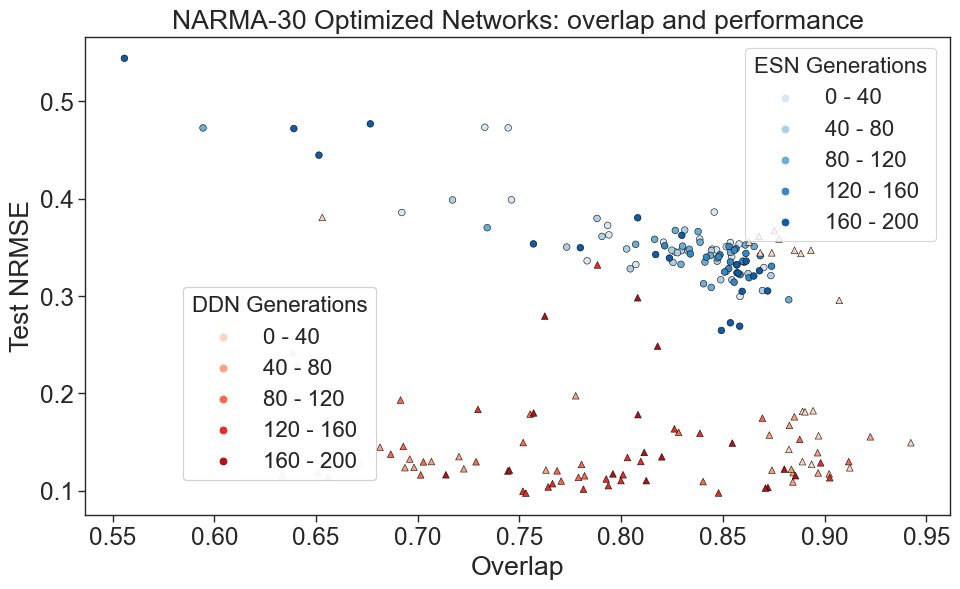

In [517]:
ddn_df = pd.DataFrame(p_ipc_dict_ddn)
bl_df = pd.DataFrame(p_ipc_dict_bl)

sns.set_theme(style="ticks", font_scale=2, palette='deep', context='paper')
fig, ax = plt.subplots(figsize=(10, 6))

n_bins = 5
n_steps = int(200/n_bins)
gen_bins = [str(i * n_steps) + ' - ' + str((i+1) * n_steps) for i in range(n_bins)]

bl_palette = sns.color_palette("Blues", len(gen_bins))
bl_df['Generation'] = pd.cut(bl_df['gen'], bins=n_bins, labels=gen_bins)

sns.scatterplot(bl_df, ax=ax, x='overlap', y='test performance', hue='Generation', palette=bl_palette, marker='o', edgecolor="black")

ddn_palette = sns.color_palette("Reds", len(gen_bins))
ddn_df['Generation'] = pd.cut(ddn_df['gen'], bins=5, labels=gen_bins)

sns.scatterplot(ddn_df, ax=ax, x='overlap', y='test performance', hue='Generation', palette=ddn_palette, marker='^', edgecolor="black")

handles_bl, labels_bl = ax.get_legend_handles_labels()
legend_bl = ax.legend(handles_bl[:len(gen_bins)], labels_bl[:len(gen_bins)], title="ESN Generations", loc='upper left', bbox_to_anchor=(0.75, 1), fontsize='small', title_fontsize='small')

handles_ddn, labels_ddn = ax.get_legend_handles_labels()
legend_ddn = ax.legend(handles_ddn[len(gen_bins):], labels_ddn[len(gen_bins):], title="DDN Generations", loc='upper left', bbox_to_anchor=(0.1, 0.5), fontsize='small', title_fontsize='small')
ax.add_artist(legend_bl)
ax.add_artist(legend_ddn)

plt.tight_layout()
plt.ylabel('Test NRMSE')
plt.xlabel('Overlap')
plt.title('NARMA-30 Optimized Networks: overlap and performance')
# plt.savefig('figs/optimized_scatter_overlap.svg')

In [605]:
best_scores, best_inds = get_best_scores(ddn_n30_results_dict, False, True)
best_gen = np.argmin(best_scores)
best_ind = best_inds[best_gen]
ex_net_ddn = ddn_n30_results_dict['example net']
best_p_ddn = ddn_n30_results_dict['parameters'][best_gen, best_ind, :]
best_scores, best_inds = get_best_scores(bl_n30_results_dict, False, True)
best_gen = np.argmin(best_scores)
best_ind = best_inds[best_gen]
ex_net_bl = bl_n30_results_dict['example net']
best_p_bl = bl_n30_results_dict['parameters'][best_gen, best_ind, :]

# data_train = np.array(createNARMA30(7000)).reshape((2, 7000))
data_val = np.array(createNARMA30(10000)).reshape((2, 10000))
ipc_in = data_val[0, 400:]
ipc_in = ipc_in * 4 - 1

maxdeg = 2
maxdel = 45
maxvar = 2
reps = 10

Vs_ddn = []
Ms_ddn = []
Vs_bl = []
Ms_bl = []
for i in range(reps):
    best_net_ddn = ex_net_ddn.get_new_network_from_serialized(best_p_ddn)
    best_net_bl = ex_net_bl.get_new_network_from_serialized(best_p_bl)

    sim = NetworkSimulator(best_net_ddn)
    sim.warmup(data_val[0, :400])
    states = sim.get_network_data(data_val[0, 400:])
    ipc = full_IPC(ipc_in, states.T, maxdel=maxdel, maxdeg=maxdeg, maxvars=maxvar)
    V = cap2vec(ipc, maxdel = maxdel, maxdeg = maxdeg)
    M = cap2mat(ipc, maxdel = maxdel, maxdeg = maxdeg, maxwin=31)
    Vs_ddn.append(V)
    Ms_ddn.append(M)
    
    sim = NetworkSimulator(best_net_bl)
    sim.warmup(data_val[0, :400])
    states = sim.get_network_data(data_val[0, 400:])
    ipc = full_IPC(ipc_in, states.T, maxdel=maxdel, maxdeg=maxdeg, maxvars=maxvar)
    V = cap2vec(ipc, maxdel = maxdel, maxdeg = maxdeg)
    M = cap2mat(ipc, maxdel = maxdel, maxdeg = maxdeg, maxwin=31)
    Vs_bl.append(V)
    Ms_bl.append(M)

test
Estimated rank of state covariance matrix =  100
Total score for degree  1  =  31.192625375699926 (cumulative total =  31.192625375699926 )
Total score for degree  2  =  37.409081649554665 (cumulative total =  68.60170702525461 )
Total capacity=68.602 (68.60 percent)
test
Estimated rank of state covariance matrix =  100
Total score for degree  1  =  38.94974657220804 (cumulative total =  38.94974657220804 )
Total score for degree  2  =  44.586653567872176 (cumulative total =  83.53640014008035 )
Total capacity=83.536 (83.54 percent)
test
Estimated rank of state covariance matrix =  99
Total score for degree  1  =  28.929522373211313 (cumulative total =  28.929522373211313 )
Total score for degree  2  =  30.921732607753672 (cumulative total =  59.851254980965024 )
Total capacity=59.851 (59.85 percent)
test
Estimated rank of state covariance matrix =  100
Total score for degree  1  =  38.10349689051377 (cumulative total =  38.10349689051377 )
Total score for degree  2  =  42.5162273

In [606]:
Citer=CAP.capacity_iterator(mindel=1,mindeg=1, maxdeg=maxdeg, minvars=1,maxvars=maxvar, maxdel=maxdel, delskip=100,
                            m_delay=False,
                            m_windowpos=False, m_window=False, m_powerlist=False,m_variables=False,
                            m_degrees=False, minwindow=0, maxwindow=31)#, verbose = 1)


task_totalcap_30, task_allcaps_30, task_numcaps_30, task_nodes_30 = Citer.collect(ipc_in, np.expand_dims(data_val[1, 400:], 1))

V30 = cap2vec(task_allcaps_30, maxdel = maxdel, maxdeg = maxdeg)
M30 = cap2mat(task_allcaps_30, maxdel = maxdel, maxdeg = maxdeg, maxwin=31)

test
Total score for degree  1  =  0.839607401231608 (cumulative total =  0.839607401231608 )
Total score for degree  2  =  0.14904644646679988 (cumulative total =  0.9886538476984079 )
Total capacity=0.989 (98.87 percent)


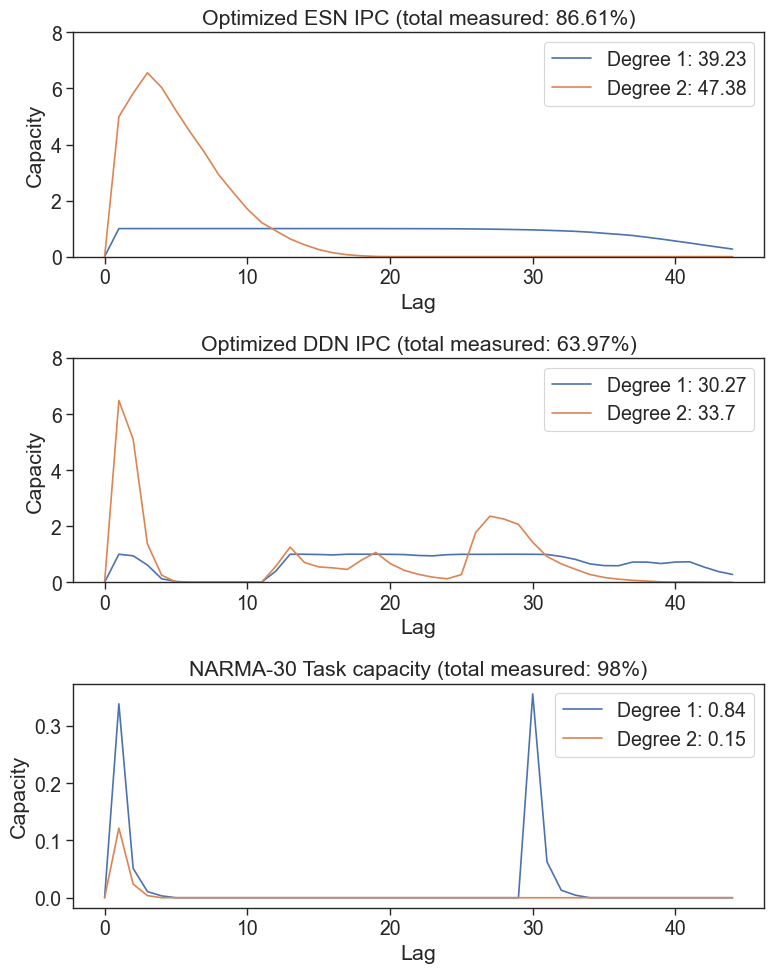

In [617]:
fig, ax = plt.subplots(3, 1, figsize=(8,10))
sns.set_theme(style="ticks", font_scale=1.6, palette='deep', context='paper')
V_arr = np.array(Vs_ddn)
av_Vs = np.mean(V_arr, axis=0)
total_Vs = np.sum(av_Vs, axis=0)
ax[1].set_title('Optimized DDN IPC (total measured: ' + str(np.round(np.sum(total_Vs), 2)) + '%)')
ax[1].plot(av_Vs)
ax[1].set_ylim(0, 8)
leg = ['Degree ' + str(i + 1) + ': ' + str(np.round(total_Vs[i], 2)) for i in range(maxdeg)]
ax[1].legend(leg)
ax[1].set_ylabel('Capacity')
ax[1].set_xlabel('Lag')

V_arr = np.array(Vs_bl)
av_Vs = np.mean(V_arr, axis=0)
total_Vs = np.sum(av_Vs, axis=0)
ax[0].set_title('Optimized ESN IPC (total measured: ' + str(np.round(np.sum(total_Vs), 2)) + '%)')
ax[0].plot(av_Vs)
ax[0].set_ylim(0, 8)
ax[0].set_ylabel('Capacity')
ax[0].set_xlabel('Lag')

leg = ['Degree ' + str(i + 1) + ': ' + str(np.round(total_Vs[i], 2)) for i in range(maxdeg)]
ax[0].legend(leg)

ax[2].plot(V30)
ax[2].set_title('NARMA-30 Task capacity (total measured: ' + str(int(np.sum(V30) * 100)) + '%)')
leg = ['Degree ' + str(i + 1) + ': ' + str(np.round(np.sum(V30[:, i]), 2)) for i in range(maxdeg)]
ax[2].legend(leg)
ax[2].set_ylabel('Capacity')
ax[2].set_xlabel('Lag')
plt.tight_layout()
# plt.legend(['degree 1', 'degree 2'])
# plt.ylabel('Capacity')
# plt.xlabel('Lag')
plt.savefig('figs/best_IPC_opt.svg')

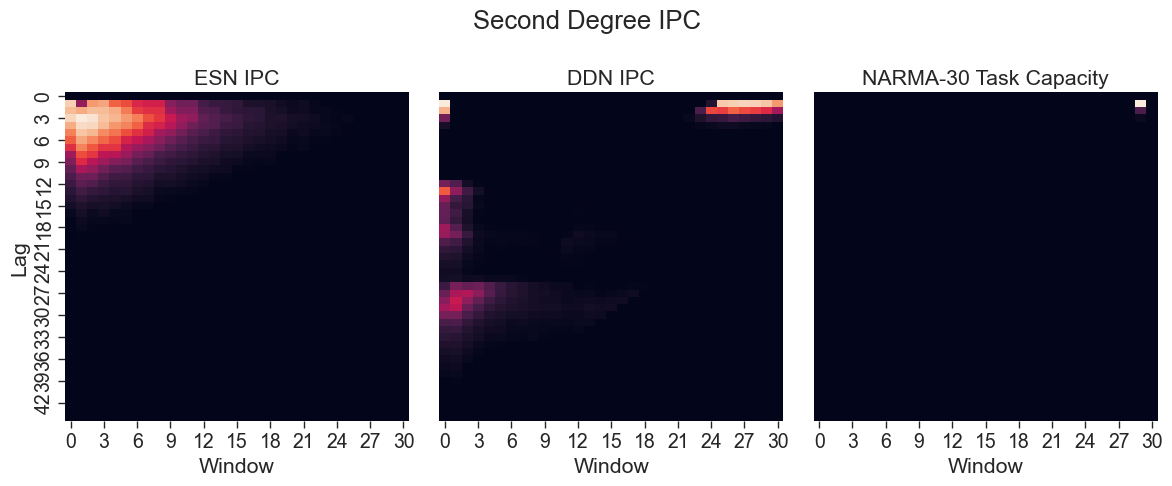

In [642]:
sns.set_theme(style="ticks", font_scale=1.6, palette='deep', context='paper')

fig, ax = plt.subplots(1, 3, figsize=(12,5), gridspec_kw={'width_ratios': [1, 1, 1]})

MIPC = np.array(Ms_ddn)
av_M_ddn = np.mean(MIPC, axis=0)

MIPC = np.array(Ms_bl)
av_M_bl = np.mean(MIPC, axis=0)

MIPC_30 = np.array(M30)

sns.heatmap(av_M_bl[:, :, 1], ax=ax[0], cbar=False)
sns.heatmap(av_M_ddn[:, :, 1], ax=ax[1], cbar=False, yticklabels=False)
sns.heatmap(MIPC_30[:, :, 1], ax=ax[2], cbar=False, yticklabels=False)
ax[0].set_ylabel('Lag')
ax[0].set_xlabel('Window')
ax[1].set_xlabel('Window')
ax[2].set_xlabel('Window')
ax[0].set_title('ESN IPC')
ax[1].set_title('DDN IPC')
ax[2].set_title('NARMA-30 Task Capacity')
fig.suptitle('Second Degree IPC')
plt.tight_layout()
plt.savefig('figs/IPC_window.svg')

<AxesSubplot: >

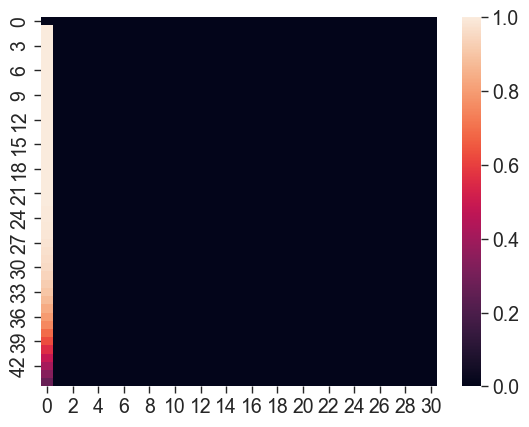

In [612]:
MIPC = np.array(Ms_bl)
av_M = np.mean(MIPC, axis=0)
sns.heatmap(av_M[:, :, 0])

In [644]:
padded_input_train = np.random.randint(0, 2, 1000)

In [645]:
print(padded_input_train)

[0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 1 0
 1 0 0 0 1 1 0 0 0 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 0 0 1
 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1 1 1 0 1 0 0
 1 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 0
 1 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 0 0 1 0 1 1 0 0 0 0 1 0 1 1 0
 0 1 1 1 1 0 1 1 0 1 0 1 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 1 1 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 0 0 0 1 0 0 0 1 0 0
 1 0 0 1 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1
 0 0 0 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0
 1 0 0 1 0 1 1 1 0 0 1 0 0 0 1 1 1 1 0 1 0 1 1 0 1 0 0 1 1 0 1 0 1 1 1 1 1
 0 0 0 1 1 0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 0 0
 0 0 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 0 1 0 0 0 0 0 1
 1 0 1 1 1 0 1 0 0 0 0 1 